In [1]:
with open('../HDFS_v1/HDFS.log', 'r') as f:
    for _ in range(5):
        print(f.readline())

081109 203518 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010

081109 203518 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906

081109 203519 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010

081109 203519 145 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010

081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_-1608999687919862906 terminating



In [1]:
import polars as pl

# все в ленивых вычислениях тк > 11кк строк
df = pl.scan_csv("../HDFS_v1/HDFS.log", has_header=False, separator="\n", new_columns=["og"])
df = df.with_columns(
    pl.col("og").str.extract(r"(blk_-?\d+)", 1).alias("BlockId"),
    pl.col("og")
        .str.to_lowercase()
        .str.replace_all(r"/?\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}(:\d*)?\.?", "") # /10.251.215.16:50010
        .str.replace_all(r"blk_-?[0-9]+\.?", "")
        .str.replace_all(r" : ", ":")
        .str.replace_all(r"[0-9,]", "")
        .str.replace_all(r"\s+", " ")
        .str.strip_chars()
        .alias("Text")
)

In [2]:
# приджойним аномальные лейблы
anomaly_label = pl.scan_csv("../HDFS_v1/preprocessed/anomaly_label.csv")
df = df.join(anomaly_label, on="BlockId", how="left")

## 3. Частотный анализ сообщений (ключевые слова, биграммы).

### unigrams

In [3]:
# ключевые слова для аномальных
anomaly = (
    df.filter(pl.col("Label") == "Anomaly")
    .select(pl.col("Text").str.split(by=" ").alias("Words"))
)

unigram_anomaly = (
    anomaly.explode("Words")
    .group_by("Words")
    .len()
    .sort("len", descending=True)
)
unigram_anomaly = unigram_anomaly.with_columns(
    (pl.col("len")/pl.col("len").sum()*100).alias("Percentage")
)
unigram_anomaly = unigram_anomaly.collect()
unigram_anomaly.write_csv("unigram_anomaly.csv")

In [4]:
unigram_anomaly.head(10)

Words,len,Percentage
str,u32,f64
"""info""",273630,13.061029
"""block""",177679,8.481053
"""to""",121339,5.791807
"""block*""",95728,4.569332
"""dfs.fsnamesystem:""",95728,4.569332
"""size""",78829,3.762701
"""dfs.datanode$dataxceiver:""",73942,3.529433
"""is""",72190,3.445805
"""added""",72179,3.44528


In [5]:
# ключевые слова для нормальных
normal = (
    df.filter(pl.col("Label") == "Normal")
    .select(pl.col("Text").str.split(by=" ").alias("Words"))
)
    
unigram_normal = (
    normal.explode("Words")
    .group_by("Words")
    .len()
    .sort("len", descending=True)
)

unigram_normal = unigram_normal.with_columns(
    (pl.col("len")/pl.col("len").sum()*100).alias("Percentage")
)
unigram_normal = unigram_normal.collect()
unigram_normal.write_csv("unigram_normal.csv")

In [6]:
unigram_normal.head(10)

Words,len,Percentage
str,u32,f64
"""info""",10539206,13.673049
"""block""",6818007,8.845348
"""to""",3821516,4.957847
"""dfs.fsnamesystem:""",3604517,4.676323
"""block*""",3604517,4.676323
"""size""",3356786,4.354929
"""dfs.datanode$packetresponder:""",3349338,4.345267
"""added""",3043736,3.948794
"""is""",3043736,3.948794


In [7]:
# для каких частых (>1% встречаемости) слов есть значительная разница в частоте в аномальных и нормальных логах
diff = (
    unigram_normal.filter(pl.col("Percentage") > 1)
    .join(unigram_anomaly.filter(pl.col("Percentage") > 1), on="Words", how="full")
    .filter(abs(pl.coalesce(pl.col("Percentage"),0)-pl.coalesce(pl.col("Percentage_right"),0)) >= 1)
)
diff

Words,len,Percentage,Words_right,len_right,Percentage_right
str,u32,f64,str,u32,f64
"""dfs.datanode$packetresponder:""",3349338,4.345267,"""dfs.datanode$packetresponder:""",64012,3.055449


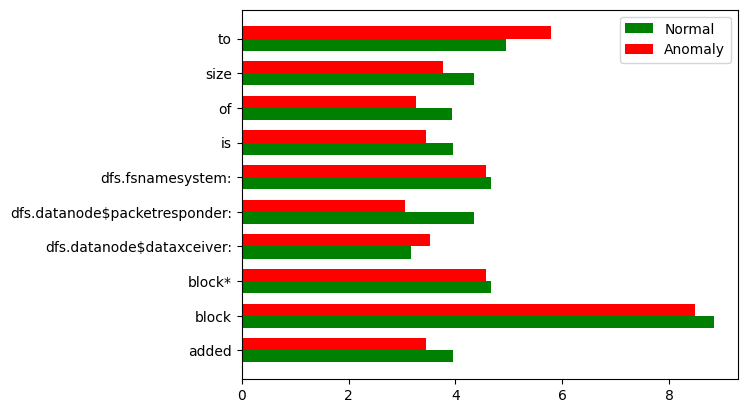

In [8]:
import matplotlib.pyplot as plt
import numpy as np

df_n = unigram_normal[1:11].sort("Words") # пропускаем info тк это просто уровень лога
df_a = unigram_anomaly[1:11].sort("Words")

fig, ax = plt.subplots()
y_pos = np.arange(10)
bar_height = 0.35
ax.barh(y_pos - bar_height/2, df_n["Percentage"], height=bar_height, label='Normal', color='g')
ax.barh(y_pos + bar_height/2, df_a["Percentage"], height=bar_height, label='Anomaly', color='r')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_n['Words'])
ax.legend()
plt.show()

В частоте ключевых слов значимой разницы нет, что в целом ожидаемо. Значимая разница есть только для ключевого слова dfs.datanode$packetresponder, оно на 1% чаще встречается в нормальных логах.

dfs.datanode$packetresponder - компонента датаноды, которая подтверждает получение блока. Возможно в аномальных логах иногда некорректно обрабатывается сигнал датаноды. Посмотрим на биграммы для более конкретных выводов.

### биграммы

In [12]:
# биграммы для аномальных
bigram_anomaly = anomaly.with_columns(
    pl.col("Words").map_elements(lambda lst: [" ".join(lst[i:i+2]) for i in range(len(lst)-1)], return_dtype=pl.List(pl.String))
    .alias("Bigrams")
)
bigram_anomaly = (
    bigram_anomaly.explode("Bigrams")
    .group_by("Bigrams")
    .len()
    .sort("len", descending=True)
)
bigram_anomaly = bigram_anomaly.with_columns(
    (pl.col("len")/pl.col("len").sum()*100).alias("Percentage")
)
bigram_anomaly = bigram_anomaly.collect()
bigram_anomaly.write_csv("bigram_anomaly.csv")

In [10]:
bigram_anomaly.head(10)

Bigrams,len,Percentage
str,i64,f64
"""dfs.fsnamesystem: block*""",95728,5.298321
"""info dfs.fsnamesystem:""",94756,5.244523
"""added to""",72179,3.994939
"""is added""",72179,3.994939
"""info dfs.datanode$dataxceiver:""",65683,3.635401
"""info dfs.datanode$packetrespon…",64012,3.542915
"""src: dest:""",50425,2.790906
"""block src:""",50425,2.790906
"""receiving block""",45945,2.542948


In [ ]:
# биграммы для нормальных
bigram_normal = normal.with_columns(
    pl.col("Words").map_elements(lambda lst: [" ".join(lst[i:i+2]) for i in range(len(lst)-1)], return_dtype=pl.List(pl.String))
    .alias("Bigrams")
)
bigram_normal = (
    bigram_normal.explode("Bigrams")
    .group_by("Bigrams")
    .len()
    .sort("len", descending=True)
)
bigram_normal = bigram_normal.with_columns(
    (pl.col("len")/pl.col("len").sum()*100).alias("Percentage")
)
bigram_normal = bigram_normal.collect(engine="streaming")
bigram_normal.write_csv("bigram_normal.csv")

In [4]:
bigram_normal.head(10)

Bigrams,len,Percentage
str,i64,f64
"""dfs.fsnamesystem: block*""",3604517,5.445485
"""info dfs.fsnamesystem:""",3604514,5.44548
"""info dfs.datanode$packetrespon…",3349338,5.059976
"""is added""",3043736,4.598291
"""added to""",3043736,4.598291
"""info dfs.datanode$dataxceiver:""",2096788,3.1677
"""block src:""",1679904,2.537897
"""src: dest:""",1679904,2.537897
"""block* namesystem.addstoredblo…",1679500,2.537286


In [30]:
# для каких биграмм есть значительная разница в частоте в аномальных и нормальных логах
diff = (
    bigram_normal
    .join(bigram_anomaly, on="Bigrams", how="full")
    .filter(abs(pl.coalesce(pl.col("Percentage"),0)-pl.coalesce(pl.col("Percentage_right"),0)) >= 1)
)
diff

Bigrams,len,Percentage,Bigrams_right,len_right,Percentage_right
str,i64,f64,str,i64,f64
"""info dfs.datanode$packetrespon…",3349338,5.059976,"""info dfs.datanode$packetrespon…",64012,3.542915


Опять видим чуть больший процент упоминаний dfs.datanode$packetresponder в нормальных логах. Посмотрим на триграммы.

### trigram

In [ ]:
# триграммы для аномальных
trigram_anomaly = anomaly.with_columns(
    pl.col("Words").map_elements(lambda lst: [" ".join(lst[i:i+3]) for i in range(len(lst)-2)], return_dtype=pl.List(pl.String))
    .alias("Trigrams")
)
trigram_anomaly = (
    trigram_anomaly.explode("Trigrams")
    .group_by("Trigrams")
    .len()
    .sort("len", descending=True)
)
trigram_anomaly = trigram_anomaly.with_columns(
    (pl.col("len")/pl.col("len").sum()*100).alias("Percentage")
)
trigram_anomaly = trigram_anomaly.collect()
trigram_anomaly.write_csv("trigram_anomaly.csv")

In [8]:
trigram_anomaly.head(10)

Trigrams,len,Percentage
str,i64,f64
"""info dfs.fsnamesystem: block*""",94756,6.24006
"""is added to""",72179,4.753275
"""block src: dest:""",50425,3.320687
"""receiving block src:""",45945,3.025661
"""dfs.datanode$dataxceiver: rece…",45945,3.025661
"""info dfs.datanode$dataxceiver:…",45945,3.025661
"""dfs.fsnamesystem: block* names…",42504,2.799058
"""blockmap updated: is""",40256,2.651018
"""updated: is added""",40256,2.651018


In [ ]:
# триграммы для нормальных
trigram_normal = normal.with_columns(
    pl.col("Words").map_elements(lambda lst: [" ".join(lst[i:i+3]) for i in range(len(lst)-2)], return_dtype=pl.List(pl.String))
    .alias("Trigrams")
)
trigram_normal = (
    trigram_normal.explode("Trigrams")
    .group_by("Trigrams")
    .len()
    .sort("len", descending=True)
)
trigram_normal = trigram_normal.with_columns(
    (pl.col("len")/pl.col("len").sum()*100).alias("Percentage")
)
trigram_normal = trigram_normal.collect(engine="streaming")
trigram_normal.write_csv("trigram_normal.csv")

In [6]:
trigram_normal.head(10)

Trigrams,len,Percentage
str,i64,f64
"""info dfs.fsnamesystem: block*""",3604514,6.517473
"""is added to""",3043736,5.503507
"""block src: dest:""",1679904,3.037505
"""dfs.fsnamesystem: block* names…",1679500,3.036775
"""namesystem.addstoredblock: blo…",1679485,3.036747
"""updated: is added""",1679485,3.036747
"""blockmap updated: is""",1679485,3.036747
"""added to size""",1679485,3.036747
"""block* namesystem.addstoredblo…",1679485,3.036747


In [35]:
diff = (
    trigram_normal
    .join(trigram_anomaly, on="Trigrams", how="full")
    .filter(abs(pl.coalesce(pl.col("Percentage"),0)-pl.coalesce(pl.col("Percentage_right"),0)) >= 0.9)
)
diff

Trigrams,len,Percentage,Trigrams_right,len_right,Percentage_right
str,i64,f64,str,i64,f64
"""info dfs.datanode$packetrespon…",1674669,3.028039,"""info dfs.datanode$packetrespon…",32167,2.118325
"""packetresponder for block""",1674669,3.028039,"""packetresponder for block""",32059,2.111213
"""dfs.datanode$packetresponder: …",1674669,3.028039,"""dfs.datanode$packetresponder: …",32059,2.111213
"""for block terminating""",1674669,3.028039,"""for block terminating""",32010,2.107986
"""dfs.datanode$packetresponder: …",1674669,3.028039,"""dfs.datanode$packetresponder: …",31845,2.09712
"""of size from""",1674669,3.028039,"""of size from""",31845,2.09712
"""info dfs.datanode$packetrespon…",1674669,3.028039,"""info dfs.datanode$packetrespon…",31845,2.09712
"""received block of""",1674669,3.028039,"""received block of""",31845,2.09712
"""block of size""",1674669,3.028039,"""block of size""",31845,2.09712


Тут дополнительно видим небольшую (<1%) разницу в триграммах, связанных с передачей блоков (packetresponder for block, for block terminating, received block of size). Опять же, это скорее всего указывает на то, что в аномальных логах передача блоков иногда прерывается до получчения ответа от датаноды. 

В целом по количественному анализу можно увидеть, что в аномальных логах передача данных прерывается до получения ответа от датаноды в приблизительно 1% случаев. Более подробные выводы можно будет сделать, проанализировав последовательности событий в логах.

## b. Глубокий семантический анализ (NLP) TF-IDF, Word2Vec, Sentence-BERT

In [3]:
# сджойним текст для каждого блока
df_agg = df.group_by("BlockId", maintain_order=True).agg(
        FullText = pl.col("Text").str.join("\n"),
        Label = pl.col("Label").max()
    ).collect()

### TF-IDF
https://habr.com/ru/companies/otus/articles/755772/

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 4), max_df=0.95, min_df=2,) #юниграммы не берем
tfidf = tfidf_vectorizer.fit_transform(df_agg["FullText"])

In [83]:
import numpy as np
import pandas as pd


anomaly_id = df_agg["Label"] == "Anomaly"
tfidf_anomaly = tfidf[anomaly_id].mean(axis=0).A1
tfidf_normal = tfidf[~anomaly_id].mean(axis=0).A1
diff = abs(tfidf_anomaly - tfidf_normal)

terms = tfidf_vectorizer.get_feature_names_out()
top_id = np.argsort(diff)[::-1]
data = {
    'ngram': [terms[i] for i in top_id],
    'Normal': [round(tfidf_normal[i], 4) for i in top_id],
    'Anomaly': [round(tfidf_anomaly[i], 4) for i in top_id],
    'Diff': [round(diff[i], 5) for i in top_id]
}
df = pd.DataFrame(data)
df.to_csv("tfidf.csv", index=False)
df[0:50]

,ngram,Normal,Anomaly,Diff
0,from info dfs fsnamesystem,0.0673,0.0123,0.05500
1,invalidset of info dfs,0.0924,0.0376,0.05481
2,invalidset of info,0.0924,0.0376,0.05481
3,of info,0.0924,0.0376,0.05481
4,of info dfs,0.0924,0.0376,0.05481
5,to invalidset of info,0.0924,0.0376,0.05481
6,delete is added to,0.0924,0.0377,0.05468
7,delete is added,0.0924,0.0377,0.05468
8,delete is,0.0924,0.0377,0.05468
9,added to invalidset of,0.0924,0.0377,0.05468


В нормальных логах немного чаще встречаются стандартные сообщения датаноды и неймноды.

Также интересно посмотреть на н-граммы, кторые встречаются только в аномальных логах:

In [88]:
df[df["Normal"] == 0][0:50]

,ngram,Normal,Anomaly,Diff
57,warn dfs fsdataset,0.0,0.0334,0.03338
58,block blockinfo not,0.0,0.0334,0.03338
59,warn dfs fsdataset unexpected,0.0,0.0334,0.03338
60,block blockinfo not found,0.0,0.0334,0.03338
61,block blockinfo,0.0,0.0334,0.03338
62,fsdataset unexpected,0.0,0.0334,0.03338
63,fsdataset unexpected error trying,0.0,0.0334,0.03338
64,blockinfo not found in,0.0,0.0334,0.03338
65,not found,0.0,0.0334,0.03338
66,trying to,0.0,0.0334,0.03338


Только в аномальных логах часто встречаются н-граммы (вероятно связаные ошибки, так как частота одинаковая):
- ошибки при попытке удаления несуществующих блоков (fsdataset unexpected error trying to delete block)
- java ошибки (received exception java io ioexception)
- ошибки записи блоков (dataxceiver writeblock received exception)

Для наглядности попробуем найти соседние слова с Word2Vec 

### Word2Vec
https://radimrehurek.com/gensim/models/word2vec.html

https://www.geeksforgeeks.org/nlp/word2vec-with-gensim/

In [5]:
from gensim.models import Word2Vec


words = [text.split() for text in df_agg["FullText"]]
model = Word2Vec(words, vector_size=100, window=5, min_count=1000, workers=4, sg=1)

In [6]:
model_keys = model.wv.key_to_index
print(sorted([w for w in model_keys]))

['/mnt/hadoop/dfs/data/current/', '/mnt/hadoop/dfs/data/current/subdir/', '/user/root/rand/_temporary/_task___m__/part-.', '/user/root/randtxt/_temporary/_task___m__/part-.', '/user/root/sortrand/_temporary/_task___r__/part-.', '/user/root/wcnt/_temporary/_task___r__/part-.', ':got', ':transmitted', 'added', 'addstoredblock', 'any', 'ask', 'belong', 'block', 'block*', 'blockinfo', 'blockmap', 'but', 'could', 'datanode(s)', 'delete', 'deleting', 'dest:', 'dfs.datablockscanner:', 'dfs.datanode$blockreceiver:', 'dfs.datanode$datatransfer:', 'dfs.datanode$dataxceiver:', 'dfs.datanode$packetresponder:', 'dfs.datanode:', 'dfs.fsdataset:', 'dfs.fsnamesystem:', 'does', 'empty', 'error', 'exception', 'file', 'file.', 'for', 'found', 'from', 'in', 'info', 'invalidset', 'is', 'it', 'java.io.ioexception:', 'namesystem.addstoredblock:', 'namesystem.allocateblock:', 'namesystem.delete:', 'not', 'of', 'on', 'packet', 'packetresponder', 'read', 'received', 'receiving', 'replicate', 'request', 'served'

In [7]:
model.wv.most_similar("error")

[('trying', 0.9724130034446716),
 ('unexpected', 0.944585919380188),
 ('delete', 0.9207370281219482),
 ('blockinfo', 0.8701551556587219),
 ('found', 0.8025376200675964),
 ('in', 0.7791302800178528),
 ('volumemap.', 0.7731549739837646),
 ('not', 0.6297311186790466),
 ('/mnt/hadoop/dfs/data/current/', 0.5558539032936096),
 ('belong', 0.5313904285430908)]

Слово error обычно встречается с операциями удаления блоков (trying, delete) и обращения к метаданным (blockinfo, volumemap)

In [8]:
model.wv.most_similar("warn")

[('invalidset', 0.4669589400291443),
 ('deleting', 0.44140389561653137),
 ('namesystem.delete:', 0.4286309778690338),
 ('dfs.fsdataset:', 0.40592026710510254),
 ('file', 0.3999038338661194),
 ('volumemap.', 0.3855883777141571),
 ('not', 0.3834021985530853),
 ('but', 0.3770034909248352),
 ('belong', 0.3721389174461365),
 ('any', 0.36200860142707825)]

Предупреждения связаны с изменениями метаданных (invalidset, namesystem.delete) и удалением (deleting).
Эти н-граммы реже встречаются в аномальных логах, видимо это нормальное поведение системы

In [9]:
model.wv.most_similar("writeblock")

[('java.io.ioexception:', 0.8822506666183472),
 ('dfs.datanode$blockreceiver:', 0.6905913949012756),
 ('could', 0.6823793053627014),
 ('empty', 0.5741239190101624),
 ('packet', 0.4826981723308563),
 ('for', 0.407196968793869),
 ('receiving', 0.3759833574295044),
 ('exception', 0.3731677830219269),
 ('src:', 0.37136977910995483),
 ('dest:', 0.3711698651313782)]

Тут видим java ошибки датаноды, из TF-IDF знаем, что это признак аномалий.

Дополнительно визуализируем распределение слов при помощи t-SNE

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


word_vectors = model.wv[model.wv.index_to_key]
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

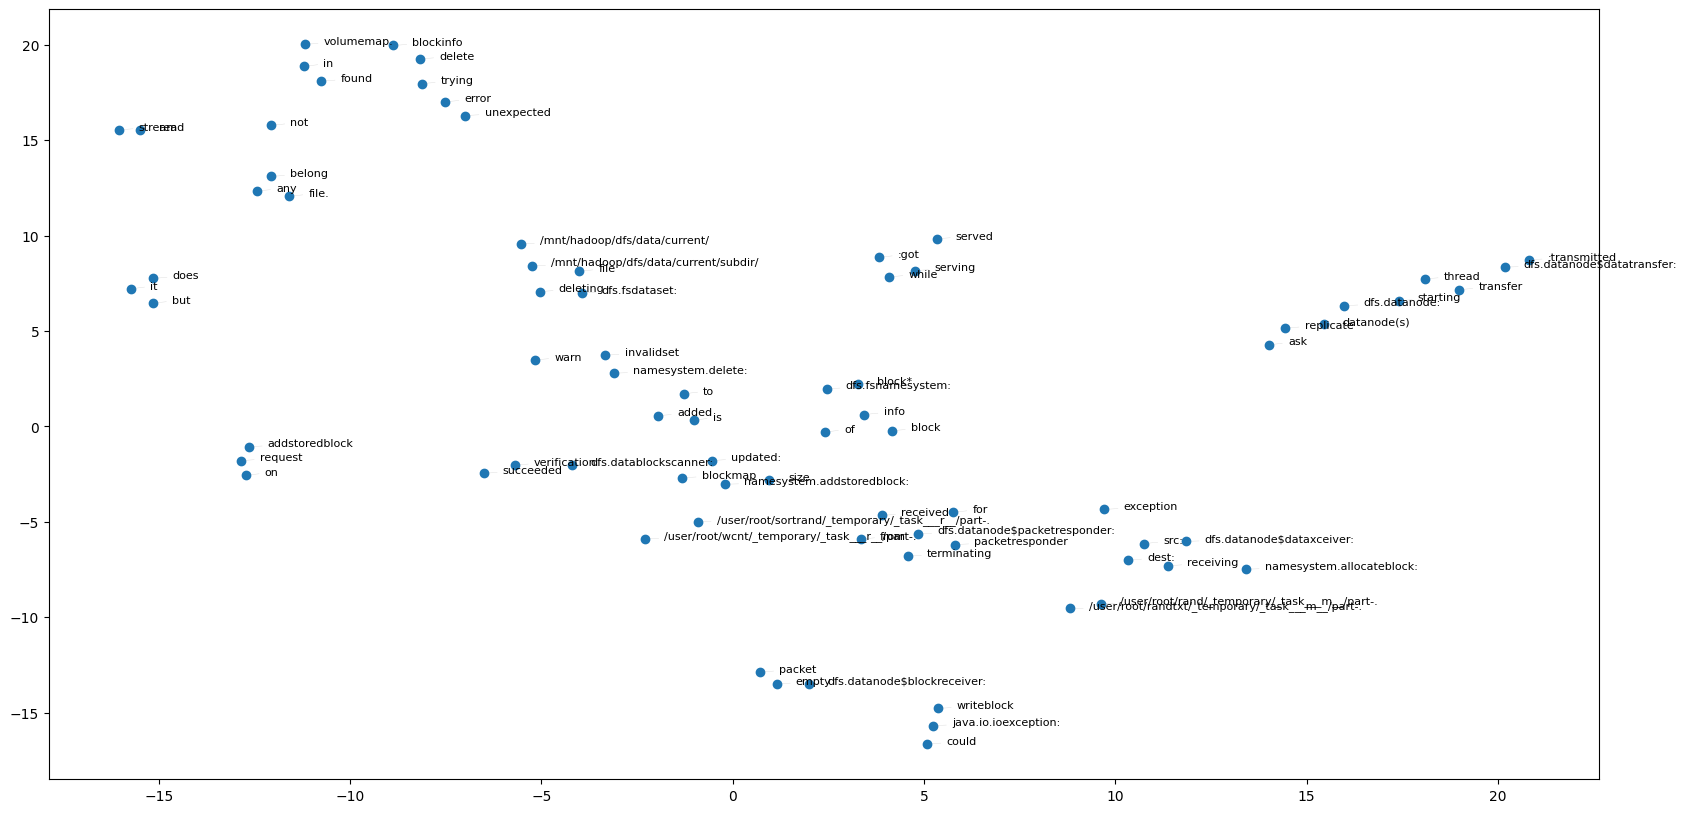

In [20]:
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
result = tsne.fit_transform(word_vectors)

plt.figure(figsize=(20, 10))
plt.scatter(result[:, 0], result[:, 1])
offset = 0.5
for i, word in enumerate(words):
    plt.annotate(
        word,
        xy=(result[i, 0], result[i, 1]),
        xytext=(result[i, 0] + offset, result[i, 1]),
        textcoords='data',
        fontsize=8,
        arrowprops=dict(arrowstyle="-", lw=0.3, color='gray', alpha=0.3)
    )
plt.savefig('word2vec.jpg') 
plt.show()

На графике видно кластеры:

- нижняя часть графика - (writeblock, java.io.ioexception, packet, blockreceiver, dataxceiver, src, dest, transfer) - java ошибки и передача данных между датанодами

- центральная часть графика - (warn, namesystem.delete, blockmap, addstoredblock, updated, allocatedblock) - связаны с неймнодой и управлением метаданными

- левая верхняя часть графика - (blockinfo, unexpected, error, not found, volumemap) - сообщения о логических ошибках и потерянных блоках - признаки аномалий

Применив TF-IDF мы выяснили, что только аномальные логи часто содержат фразы вроде: fsdataset unexpected error trying to delete block, received exception java io ioexception

При помощи Word2Vec получилось выделить семантические кластеры вокруг ключевых слов:
- error - аномальные ошибки блоков данных (delete, blockinfo, volumemap)
- warn - нормальные операции с метаданными (invalidset, fsnamesystem.delete)
- writeblock - аномальные java ошибки
